# Creating a choropleth map of geographic data

This notebook contains some Python test code to create a choropleth map of geographic data. An [SVG](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) file of [all US counties](https://commons.wikimedia.org/wiki/File:USA_Counties_with_FIPS_and_names.svg) and a [csv-file containing the estimated US population per county in 2016](https://www2.census.gov/programs-surveys/popest/datasets/2010-2016/counties/totals/) is used as a geographic data example. Interactive visualization is done using [bokeh](https://bokeh.pydata.org/). 

The SVG file was edited slightly before analysis by hand to be able to extract geographic data effectively and create an interactive bokeh plot (a whitespace was added whenever a letter follows a number in a *path* tag, e.g. *38.380,194.347M* was changed to *38.380,194.347 M*.)

## Import prerequisites:

In [1]:
import csv
from itertools import groupby
from math import log10
import re

from bs4 import BeautifulSoup

from IPython.display import SVG, display

from bokeh.io       import output_notebook, output_file, push_notebook, show
from bokeh.models   import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper, LogColorMapper, LogTicker
from bokeh.plotting import figure, save
from bokeh.palettes import magma

#output_file("bokeh_choropleth.html", title="Choropleth test")
output_notebook() # to enable Bokeh in Jupyter

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p csv,bs4,bokeh
print("")
%watermark -m

Loading BokehJS ...

Author: gmalim

last updated: Sun Jul 01 2018

CPython 3.6.5
IPython 6.4.0

csv 1.0
bs4 4.6.0
bokeh 0.13.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## Load data:

In [2]:
inputfile_data = open('data/co-est2016-alldata.csv', 'r', encoding="latin-1")

reader = csv.reader(inputfile_data, delimiter=",")

next(reader, None) # skip the headers

population = {}

for row in reader:
    
    if (row[4] == '000'): # skip states
        continue

    try:
        FIPS = row[3] + row[4]
        
        population_2016_estimate = int(row[15]) 
        
        population[FIPS] = population_2016_estimate
    except:
        pass
    
inputfile_data.close()

# Alaska boroughs that have changed since SVG map was made:

population['02201'] = population['02198']       
population['02280'] = population['02275'] + population['02195']
population['02232'] = population['02230'] + population['02105']

Load empty USA Counties SVG map:

In [3]:
inputfile_map = open('data/USA_Counties_with_FIPS_and_names.svg', 'r')

old_svg = inputfile_map.read()

inputfile_map.close()

Load SVG map into Beautiful Soup and find all counties:

In [4]:
soup = BeautifulSoup(old_svg, "lxml")

paths = soup.findAll('path')

Define county style for SVG map:

In [5]:
path_style = 'font-size:12px;'        + \
             'fill-rule:nonzero;'     + \
             'stroke:#FFFFFF;'        + \
             'stroke-opacity:1;'      + \
             'stroke-width:0.1;'      + \
             'stroke-miterlimit:4;'   + \
             'stroke-dasharray:none;' + \
             'stroke-linecap:butt;'   + \
             'marker-start:none;'     + \
             'stroke-linejoin:bevel;'

Create logarithmic color scale based on county population:

In [6]:
colors = magma(20)
colors = colors[::-1] # reverse color palette so dark corresponds to maximum value

key_min = min(population.keys(), key=(lambda k: population[k]))
key_max = max(population.keys(), key=(lambda k: population[k]))
min_rate = population[key_min]
max_rate = population[key_max]

print("--> min_rate =", min_rate)
print("--> max_rate =", max_rate)

min_rate =     1000
max_rate = 10000000

for p in paths:
     
    if p['id'] not in ["State_Lines", "separator"]:

        try:
            rate = population[p['id']]
        except:
            continue
        
        if (min_rate == 0):
            color_class = (len(colors)-1) * log10(rate) / log10(max_rate)
        else:
            color_class = (len(colors)-1) * (log10(rate) - log10(min_rate)) / (log10(max_rate) - log10(min_rate))
        
        color_class = round(color_class)
        
        if (color_class < 0):
            color_class = 0
        
        color = colors[color_class]
    
        p['style'] = path_style + 'fill:' + color

--> min_rate = 88
--> max_rate = 10137915


Capture updated SVG map in variable by using *capture* magic command:

In [7]:
%%capture captured_cell

updated_svg_map = soup.prettify()

print(updated_svg_map)

Update separator and state line colors in captured cell output:

In [8]:
new_svg = captured_cell.stdout

old_separator_text = 'id="separator" style="fill:none;stroke:#a9a9a9'
new_separator_text = 'id="separator" style="fill:none;stroke:#FFFFFF'    # i.e. separator color = white

new_svg = new_svg.replace(old_separator_text, new_separator_text)

old_stateline_text = 'id="State_Lines" style="fill:none;stroke:#221e1f'
new_stateline_text = 'id="State_Lines" style="fill:none;stroke:#FFFFFF'  # i.e. state lines color = white

new_svg = new_svg.replace(old_stateline_text, new_stateline_text)

Fix SVG hover titles:

In [9]:
pattern_string = r'<title id="t(\d+)">\n\s+([\w\s-]+,\s\w\w)\n\s+</title>'
replace_string = r'<title id="t\1">\2</title>'

new_svg = re.sub(pattern_string, replace_string, new_svg);

Display new SVG map in notebook:

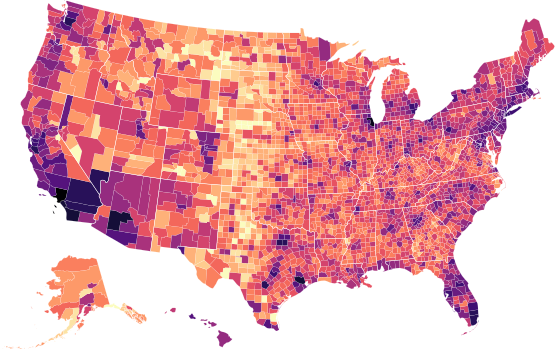

In [10]:
display(SVG(new_svg))

Save new SVG map to file:

In [11]:
updated_svg_map_filename = 'new_svg_map.svg'

outputfile = open(updated_svg_map_filename, 'w')

outputfile.write(new_svg);

Parse county data to lists:

In [12]:
county_names = []
county_rates = []
county_longitude_lists = []
county_latitude_lists  = []

state_longitude_lists = []
state_latitude_lists  = []

separator_longitude_lists = []
separator_latitude_lists  = []

for p in paths:

    county_name = p.get_text()
    
    if p['id'] not in ["State_Lines", "separator"]:
        
        try:
            rate = population[p['id']]
        except:
            rate = 0
            
        d_list = p['d'].split(' ')
        
        d_list2 = [list(group) for k, group in groupby(d_list, lambda x: x == "M") if not k]
        
        for d_list in d_list2:
        
            county_coordinate_list = [element for element in d_list if element not in ('M', 'L', 'z')]
        
            county_longitude_list = [float(element.split(",")[0])    for element in county_coordinate_list]
            county_latitude_list  = [float(element.split(",")[1])*-1 for element in county_coordinate_list]
        
            county_names.append(county_name)
            county_rates.append(rate)
            
            county_longitude_lists.append(county_longitude_list)
            county_latitude_lists .append(county_latitude_list)
            
    if (p['id'] == "State_Lines"):
        
        d_list = p['d'].split(' ')
        
        d_list2 = [list(group) for k, group in groupby(d_list, lambda x: x == "M") if not k]
        
        for d_list in d_list2:
        
            state_coordinate_list = [element for element in d_list if element not in ('M', 'L', 'z')]
        
            state_longitude_list = [float(element.split(",")[0])    for element in state_coordinate_list]
            state_latitude_list  = [float(element.split(",")[1])*-1 for element in state_coordinate_list]
        
            state_longitude_lists.append(state_longitude_list)
            state_latitude_lists .append(state_latitude_list)
        
    if (p['id'] == "separator"):
        
        d_list = p['d'].split(' ')
        
        d_list2 = [list(group) for k, group in groupby(d_list, lambda x: x == "M") if not k]
        
        for d_list in d_list2:
        
            separator_coordinate_list = [element for element in d_list if element not in ('M', 'L', 'z')]
        
            separator_longitude_list = [float(element.split(",")[0])    for element in separator_coordinate_list]
            separator_latitude_list  = [float(element.split(",")[1])*-1 for element in separator_coordinate_list]
        
            separator_longitude_lists.append(separator_longitude_list)
            separator_latitude_lists .append(separator_latitude_list)

county_names = [e[1:] for e in county_names] # remove newline in front of name

print("--> # of county patches  =", len(county_names))
print("--> # of state     lines =", len(state_longitude_lists))
print("--> # of separator lines =", len(separator_longitude_lists))

--> # of county patches  = 3276
--> # of state     lines = 51
--> # of separator lines = 2


Create interactive Bokeh plot:

In [13]:
tools = "pan,wheel_zoom,box_zoom,reset,save,hover"

factor = 1.75
width  = int(factor*555.221)
height = int(factor*351.667)

p = figure(plot_width=width, plot_height=height, tools=tools, toolbar_location="above", 
           x_axis_location=None, y_axis_location=None)
p.title.text = 'US population per county 2016'
p.grid.grid_line_color = None

#color_mapper = LinearColorMapper(low=0.01, high=10.01, palette=colors[0:-1], high_color = colors[-1])
#color_mapper = LinearColorMapper(low=min_rate, high=max_rate, palette=colors)
color_mapper = LogColorMapper(low=min_rate, high=max_rate, palette=colors)
color_mapper = LogColorMapper(low=1000, high=10000000, palette=colors)
color_bar    = ColorBar(color_mapper=color_mapper, label_standoff=15, location=(5, 0), ticker=LogTicker())
p.add_layout(color_bar, 'right')

source = ColumnDataSource(data=dict(name=county_names, 
                                    rate=county_rates,
                                    x=county_longitude_lists, 
                                    y=county_latitude_lists))

p.patches('x', 'y', source=source, #fill_alpha=0.8, 
          fill_color={'field': 'rate', 'transform': color_mapper},
          line_color="white", line_width=0.1)

p.multi_line(state_longitude_lists, state_latitude_lists,
             line_color="white", line_width=1, line_alpha=0.6)

p.multi_line(separator_longitude_lists, separator_latitude_lists,
             line_color="grey", line_width=1, line_alpha=0.3)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("County",            "@name"),
                  ("Population 2016",   "@rate"),
                  ("(x, y)",            "($x{0.00 a}, $y{0.00 a})")]

show(p)